## My Kaggle Mini Project

[Kaggle competition page](https://www.kaggle.com/c/nlp-getting-started/overview)<br>
[My repository page](https://www.kaggle.com/c/histopathologic-cancer-detection/overview)

### Step 1 Problem description


The challenge problem is to identify if an input text tweet anounces a disaster. So the input is a text made of words(maximum 31 word. See the graph and the output below). The output is a label that says if the tweet text is about an emergency situation. It is a natural language processing and binary classification task, so we need extract some useful data out of the natural language text and to use it to classify the input.

In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from keras.models import Model, Sequential
from keras.layers import Input, Activation, Dense, GRU, LSTM, Bidirectional, RepeatVector, Dropout, Embedding

from keras.losses import BinaryCrossentropy

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split


### Step 2 Exploratory data analysis
Let's inspect the structure of our data.<br>
We have tweets of different word length in the input. Whe can see the data word count histogram on the next picture:

Max word count: 31


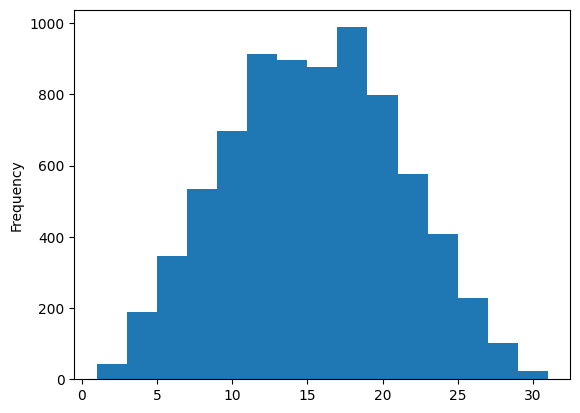

In [11]:
df = pd.read_csv('../input/nlp-getting-started/train.csv').dropna(subset=['text'])
getWordCount = lambda t: len(t.split())
word_counts = df['text'].apply(getWordCount)
word_counts.plot(kind='hist', xlabel='label', ylabel='count', bins=15)
print(f'Max word count: {word_counts.max()}')

Maximum word count on the training data tweets is 31(but we will take some bigger number for our tokenizer to be able to process bigger tweets).

Let's see how many emergency and non-emergency tweets we have.

0    4342
1    3271
Name: target, dtype: int64


<AxesSubplot:xlabel='label', ylabel='count'>

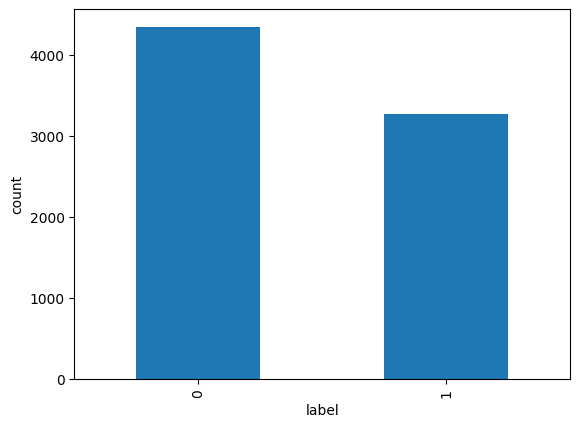

In [12]:
label10counts = df['target'].value_counts()
print(label10counts)
label10counts.plot(kind='bar', xlabel='label', ylabel='count')

We can see that our data is not balanced yet. We should better make both class element count equal.

In [13]:
train_labels_1 = df[df['target'] == 1]
train_labels_0 = df[df['target'] == 0]
df = pd.concat(
    [train_labels_1, train_labels_0.sample(n=train_labels_1.shape[0], random_state=42)]
).sample(
    frac=1, random_state=42
).reset_index(
    drop=True
)

So data is balanced now.

Let's transform the natural language text to vectors so our neural network can read it:

In [14]:
text_max_length = 50

data = df[['text', 'target']]

train, test = train_test_split(data, test_size=0.2, random_state=42)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['text'])

getSeq = lambda texts: pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=text_max_length)

train_X = getSeq(train['text'])
test_X = getSeq(test['text'])


### Step 3 Model architecture
Let's design a simple RNN. RNN is a reccurent neural network that has some sort of memory, because it's layers are recursively connected with their previous iteration's result.<br>
 It helps it to process sequences and to remember what did it read before. This is exactly what we need for this task.<br>
We can read about the RNNs in the official Tensorflow documentation: [https://www.tensorflow.org/guide/keras/rnn](https://www.tensorflow.org/guide/keras/rnn).

In [15]:
from keras.layers import SimpleRNN

model0 = Sequential([
    Embedding(len(tokenizer.word_index)+1, output_dim=64),
    SimpleRNN(64),

    Dense(64),
    Activation('relu'),
    Dense(1),
    Activation('sigmoid')
])

model0.compile(loss=BinaryCrossentropy(), optimizer=keras.optimizers.Adam(0.0001), metrics=['accuracy'])

Epoch 1/8
164/164 [==============================] - 10s 55ms/step - loss: 0.6791 - accuracy: 0.5859 - val_loss: 0.6775 - val_accuracy: 0.5760
Epoch 2/8
164/164 [==============================] - 9s 53ms/step - loss: 0.6328 - accuracy: 0.6727 - val_loss: 0.6515 - val_accuracy: 0.6280
Epoch 3/8
164/164 [==============================] - 9s 56ms/step - loss: 0.5143 - accuracy: 0.7650 - val_loss: 0.5338 - val_accuracy: 0.7418
Epoch 4/8
164/164 [==============================] - 9s 54ms/step - loss: 0.3401 - accuracy: 0.8653 - val_loss: 0.5011 - val_accuracy: 0.7617
Epoch 5/8
164/164 [==============================] - 9s 56ms/step - loss: 0.2190 - accuracy: 0.9241 - val_loss: 0.5057 - val_accuracy: 0.7693
Epoch 6/8
164/164 [==============================] - 9s 56ms/step - loss: 0.1396 - accuracy: 0.9517 - val_loss: 0.5336 - val_accuracy: 0.7716
Epoch 7/8
164/164 [==============================] - 9s 54ms/step - loss: 0.1029 - accuracy: 0.9666 - val_loss: 0.5629 - val_accuracy: 0.7662
Epoch

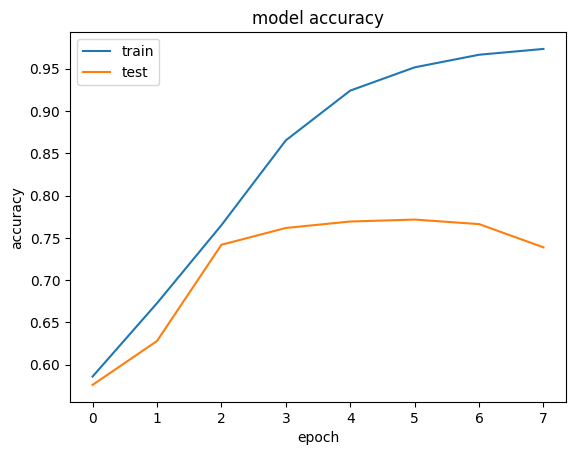

In [16]:
history = model0.fit(x=train_X, y=train['target'], validation_data=(test_X, test['target']), batch_size=32, epochs=8)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Step 4 Results and analysis
That results aren't bad, but let's try to improve them by changing the architecture.

Let's try to improve results by adding a LSTM layer.

In [17]:
model1 = Sequential([
    Embedding(len(tokenizer.word_index)+1, output_dim=64),
    LSTM(64, return_sequences=True),
    SimpleRNN(32),

    Dense(32),
    Activation('relu'),
    Dense(1),
    Activation('sigmoid')
])

model1.compile(loss=BinaryCrossentropy(), optimizer=keras.optimizers.Adam(0.0001), metrics=['accuracy'])

Epoch 1/8
164/164 [==============================] - 12s 63ms/step - loss: 0.6825 - accuracy: 0.5802 - val_loss: 0.6670 - val_accuracy: 0.6257
Epoch 2/8
164/164 [==============================] - 9s 56ms/step - loss: 0.6118 - accuracy: 0.7004 - val_loss: 0.5396 - val_accuracy: 0.7647
Epoch 3/8
164/164 [==============================] - 10s 58ms/step - loss: 0.4503 - accuracy: 0.8110 - val_loss: 0.4692 - val_accuracy: 0.7823
Epoch 4/8
164/164 [==============================] - 10s 58ms/step - loss: 0.3192 - accuracy: 0.8796 - val_loss: 0.4566 - val_accuracy: 0.7937
Epoch 5/8
164/164 [==============================] - 9s 54ms/step - loss: 0.2307 - accuracy: 0.9159 - val_loss: 0.4778 - val_accuracy: 0.7876
Epoch 6/8
164/164 [==============================] - 10s 59ms/step - loss: 0.1753 - accuracy: 0.9385 - val_loss: 0.5192 - val_accuracy: 0.7800
Epoch 7/8
164/164 [==============================] - 9s 55ms/step - loss: 0.1346 - accuracy: 0.9570 - val_loss: 0.5317 - val_accuracy: 0.7884
Ep

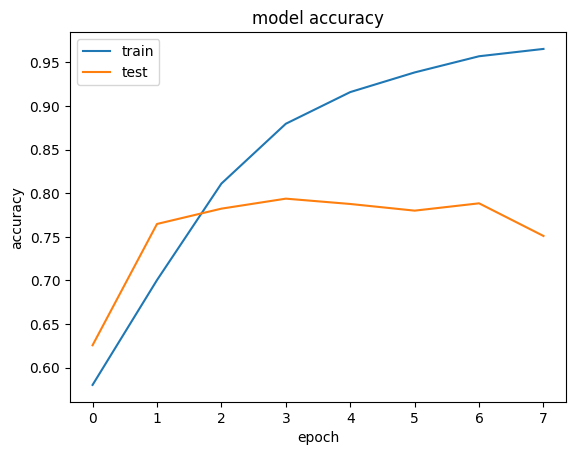

In [18]:
history = model1.fit(x=train_X, y=train['target'], validation_data=(test_X, test['target']), batch_size=32, epochs=8)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

It seems that adding a LSTM layer did not help very much. It only learns a bit slower now.<br>
Let's continue experimenting and let's change layers to GRU. 

In [19]:
model2 = Sequential([
    Embedding(len(tokenizer.word_index)+1, output_dim=128),
    GRU(128, return_sequences=True),
    GRU(64),

    Dense(64),
    Activation('relu'),
    Dense(1),
    Activation('sigmoid')
])

model2.compile(loss=BinaryCrossentropy(), optimizer=keras.optimizers.Adam(0.0001), metrics=['accuracy'])

Epoch 1/8
164/164 [==============================] - 6s 21ms/step - loss: 0.6725 - accuracy: 0.6191 - val_loss: 0.6228 - val_accuracy: 0.6662
Epoch 2/8
164/164 [==============================] - 3s 17ms/step - loss: 0.5545 - accuracy: 0.7231 - val_loss: 0.4584 - val_accuracy: 0.7922
Epoch 3/8
164/164 [==============================] - 3s 18ms/step - loss: 0.3381 - accuracy: 0.8609 - val_loss: 0.4468 - val_accuracy: 0.7998
Epoch 4/8
164/164 [==============================] - 2s 15ms/step - loss: 0.2158 - accuracy: 0.9195 - val_loss: 0.4800 - val_accuracy: 0.8060
Epoch 5/8
164/164 [==============================] - 3s 19ms/step - loss: 0.1352 - accuracy: 0.9507 - val_loss: 0.5742 - val_accuracy: 0.7800
Epoch 6/8
164/164 [==============================] - 4s 23ms/step - loss: 0.0859 - accuracy: 0.9694 - val_loss: 0.6712 - val_accuracy: 0.8021
Epoch 7/8
164/164 [==============================] - 4s 23ms/step - loss: 0.0615 - accuracy: 0.9778 - val_loss: 0.7365 - val_accuracy: 0.7716
Epoch 

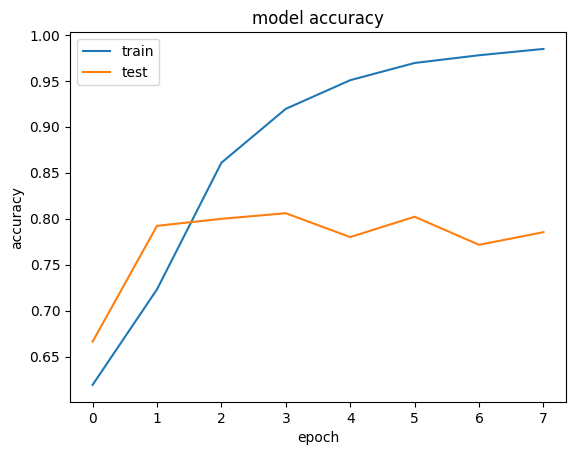

In [20]:
history = model2.fit(x=train_X, y=train['target'], validation_data=(test_X, test['target']), batch_size=32, epochs=8)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

The results got better. It seems that GRU layer learns faster. Validation accuracy got better too.<br>
To my mind, it is because GRU cells are simpler than LSTM cells while they have nearly same efficiency.<br>
Let's add dropouts.

In [21]:
model3 = Sequential([
    Embedding(len(tokenizer.word_index)+1, output_dim=128),
    GRU(128, return_sequences=True),
    GRU(64),
    Dense(64),
    Activation('relu'),
    Dropout(0.5),
    Dense(1),
    Activation('sigmoid')
])

model3.compile(loss=BinaryCrossentropy(), optimizer=keras.optimizers.Adam(0.0001), metrics=['accuracy'])

Epoch 1/8
164/164 [==============================] - 6s 21ms/step - loss: 0.6845 - accuracy: 0.5997 - val_loss: 0.6600 - val_accuracy: 0.6478
Epoch 2/8
164/164 [==============================] - 3s 16ms/step - loss: 0.5869 - accuracy: 0.6971 - val_loss: 0.4718 - val_accuracy: 0.7830
Epoch 3/8
164/164 [==============================] - 4s 23ms/step - loss: 0.3767 - accuracy: 0.8408 - val_loss: 0.4345 - val_accuracy: 0.7960
Epoch 4/8
164/164 [==============================] - 4s 22ms/step - loss: 0.2411 - accuracy: 0.9117 - val_loss: 0.4853 - val_accuracy: 0.8037
Epoch 5/8
164/164 [==============================] - 4s 23ms/step - loss: 0.1643 - accuracy: 0.9452 - val_loss: 0.5403 - val_accuracy: 0.7876
Epoch 6/8
164/164 [==============================] - 4s 22ms/step - loss: 0.1137 - accuracy: 0.9627 - val_loss: 0.6109 - val_accuracy: 0.7968
Epoch 7/8
164/164 [==============================] - 4s 23ms/step - loss: 0.0778 - accuracy: 0.9734 - val_loss: 0.7902 - val_accuracy: 0.7334
Epoch 

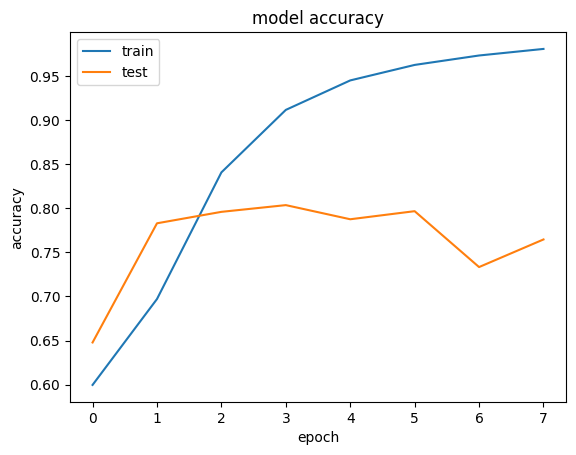

In [22]:
history = model3.fit(x=train_X, y=train['target'], validation_data=(test_X, test['target']), batch_size=32, epochs=8)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Results did not become better, only spoiled the training a bit.<br>
Let's try bidirectional reccurent layers:

In [23]:
model4 = Sequential([
    Embedding(len(tokenizer.word_index)+1, output_dim=128),
    
    Bidirectional(GRU(128, return_sequences=True)),

    Bidirectional(GRU(64)),

    Dense(64),
    Activation('relu'),
    Dropout(0.5),
    Dense(1),
    Activation('sigmoid')
])

model4.compile(loss=BinaryCrossentropy(), optimizer=keras.optimizers.Adam(0.0001), metrics=['accuracy'])

Epoch 1/8
164/164 [==============================] - 13s 38ms/step - loss: 0.6842 - accuracy: 0.5719 - val_loss: 0.6565 - val_accuracy: 0.6333
Epoch 2/8
164/164 [==============================] - 6s 35ms/step - loss: 0.5756 - accuracy: 0.7071 - val_loss: 0.4702 - val_accuracy: 0.7800
Epoch 3/8
164/164 [==============================] - 6s 35ms/step - loss: 0.3601 - accuracy: 0.8527 - val_loss: 0.4551 - val_accuracy: 0.7907
Epoch 4/8
164/164 [==============================] - 6s 35ms/step - loss: 0.2362 - accuracy: 0.9138 - val_loss: 0.5033 - val_accuracy: 0.7899
Epoch 5/8
164/164 [==============================] - 6s 36ms/step - loss: 0.1391 - accuracy: 0.9536 - val_loss: 0.6348 - val_accuracy: 0.7846
Epoch 6/8
164/164 [==============================] - 6s 37ms/step - loss: 0.0813 - accuracy: 0.9736 - val_loss: 0.7388 - val_accuracy: 0.7716
Epoch 7/8
164/164 [==============================] - 6s 37ms/step - loss: 0.0488 - accuracy: 0.9872 - val_loss: 0.8874 - val_accuracy: 0.7609
Epoch

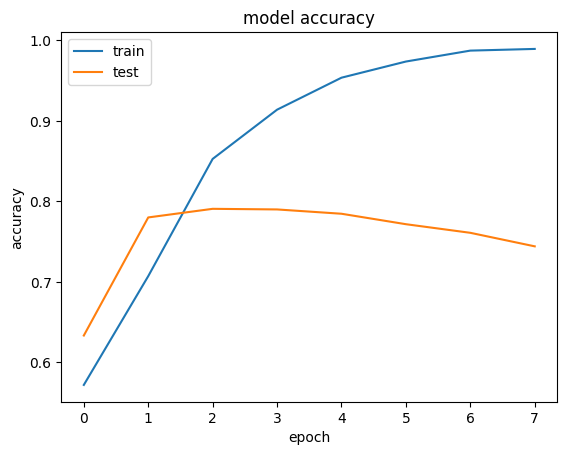

In [24]:
history = model4.fit(x=train_X, y=train['target'], validation_data=(test_X, test['target']), batch_size=32, epochs=8)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Results did not get better. Also the model is more likely overfitting now.<br>

So, we tried different architectures and according to our experience, we can say that it helped to add a GRU layer to our RNN network.<br>

Let's make a submission file for Kaggle.

In [25]:
test_df = pd.read_csv('../input/nlp-getting-started/test.csv')
test_X = test_df['text']
test_X_seq = pad_sequences(tokenizer.texts_to_sequences(test_X), text_max_length)
preds = model2.predict(test_X_seq)
preds = [i > 0.5 and 1 or 0 for i in preds]

102/102 [==============================] - 3s 15ms/step


In [27]:
submission = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')
submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [28]:
submission['target'] = preds
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [29]:
submission.to_csv('submission.csv', header=True, index=False)

## Step 5 Conclusion
So, as I said before, we tried different architectures and according to our experience, we can say that it helped to add a GRU layer to our RNN network.<br>
The things that did not help are bidirectional RNN layers and dropouts.<br>
But anyway, the changes are pretty small and the difference in the results is small too.<br>
So we can't be sure if it really helped us because of the learning randomness. For example, sometimes I tried same architectures and results were opposite.<br><br>
What would really help is if we used bad optimizer, loss etc. and then switched to better hyperparameters. But we initially used good optimizer, so there is nothing significant to improve here except the method that we use(RNNs). For example, I would try to use pretrained models to better recognize some features on the images. Also I would try to use classical ML approach to classify the data. But these methods are out of the limits of this mini project task.<br><br>

To learn the NLP-specific architecture I used next resources:<br>
[https://www.tensorflow.org/guide/keras/rnn](https://www.tensorflow.org/guide/keras/rnn)<br>
[https://keras.io/api/layers/core_layers/embedding/](https://keras.io/api/layers/core_layers/embedding/)<br>
[https://keras.io/api/layers/recurrent_layers/bidirectional/](https://keras.io/api/layers/recurrent_layers/bidirectional/)<br>
And other tensorflow and keras documentation.